In [153]:
from pathlib import Path
from pku_autonomous_driving import io, util, improc, dataset, resnet, centernet, training, graphics

import importlib
importlib.reload(io)
importlib.reload(util)
importlib.reload(improc)
importlib.reload(dataset)
importlib.reload(resnet)
importlib.reload(centernet)
importlib.reload(training)
importlib.reload(graphics)

<module 'pku_autonomous_driving.graphics' from '/Users/argon/workspace/managed/pku-autonomous-driving/pku_autonomous_driving/graphics.py'>

In [102]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [104]:
train = io.load_train_data()
train_loader, dev_loader = training.create_data_loader(train, batch_size=1, test_size=0.08)

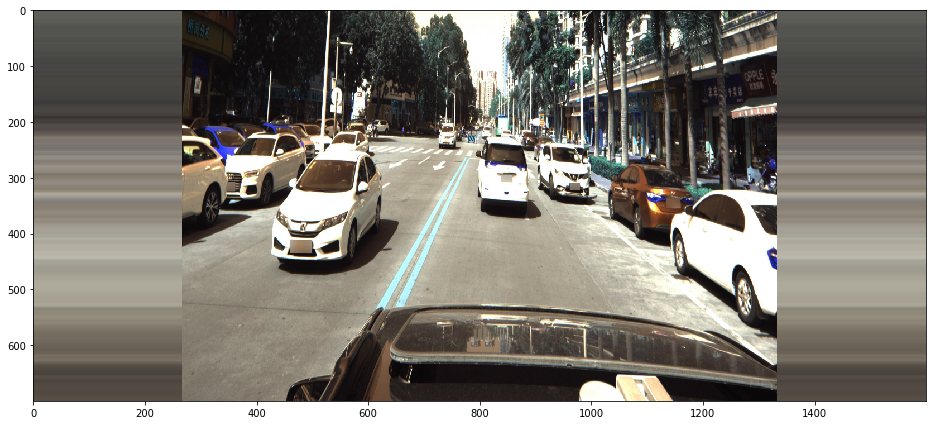

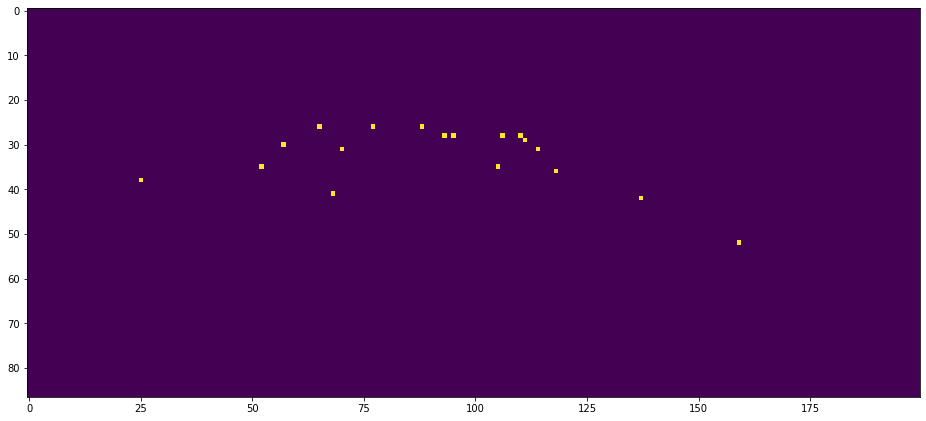

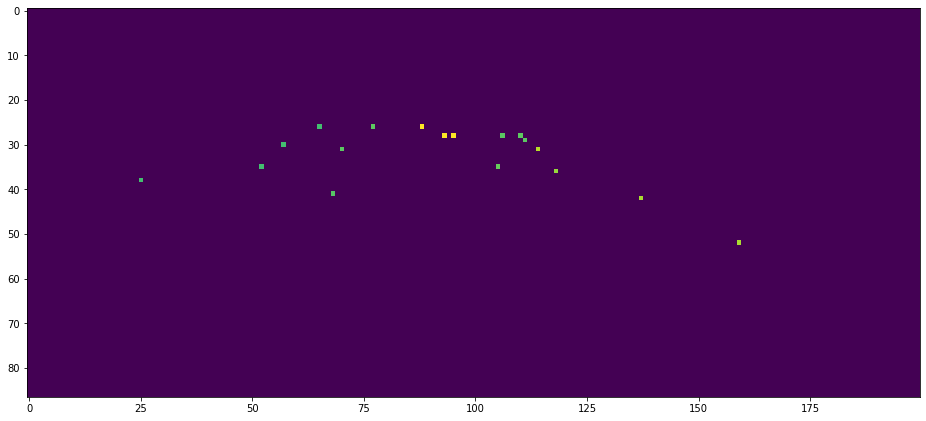

In [105]:
import matplotlib.pyplot as plt
import numpy as np

img, mask, regr = train_loader.dataset[0]

plt.figure(figsize=(16,16))
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(regr[-2])
plt.show()

In [118]:
base_model = resnet.resnext50_32x4d(pretrained=False)
model = centernet.CentResnet(base_model, 8)
util.setup_model(model, device, Path("../input/pkuautonomousdrivingtraining/resnext50.pth"))

In [9]:
%%time
from torch import optim
from torch.optim import lr_scheduler
import pandas as pd

n_epochs = 4

optimizer = optim.AdamW(model.parameters(), lr=0.001)
#optimizer =  RAdam(model.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

history = pd.DataFrame()
for epoch in range(n_epochs):
    training.clean_up()
    training.train(model, optimizer, exp_lr_scheduler, train_loader, epoch, device, history)
    training.evaluate(model, dev_loader, epoch, device, history)

dafdsfasdf


KeyboardInterrupt: 

In [52]:
torch.save(model.state_dict(), './resnext50.pth')

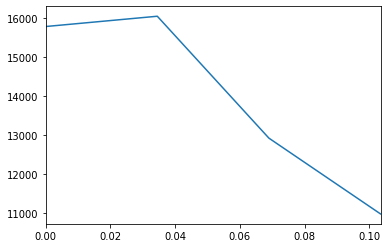

In [55]:
history['train_loss'].iloc[:].plot();

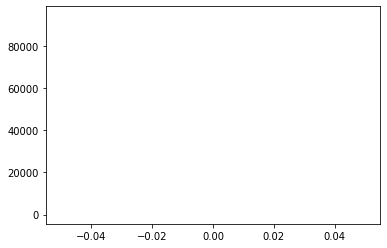

In [56]:
series1 = history.dropna()['mask_loss']
plt.plot(series1.index, series1 ,label = 'mask loss');
series2 = history.dropna()['regr_loss']
plt.plot(series2.index, 30*series2,label = 'regr loss');
series3 = history.dropna()['dev_loss']
plt.plot(series3.index, series3,label = 'dev loss');
plt.show()

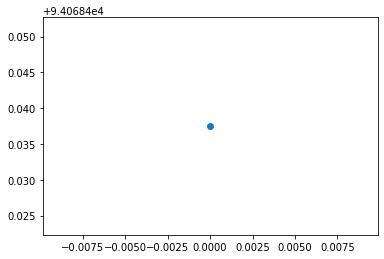

In [57]:
series = history.dropna()['dev_loss']
plt.scatter(series.index, series);

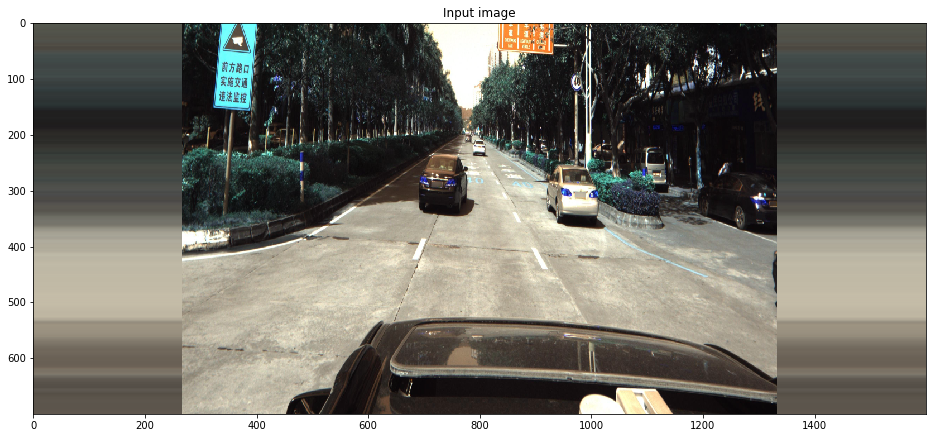

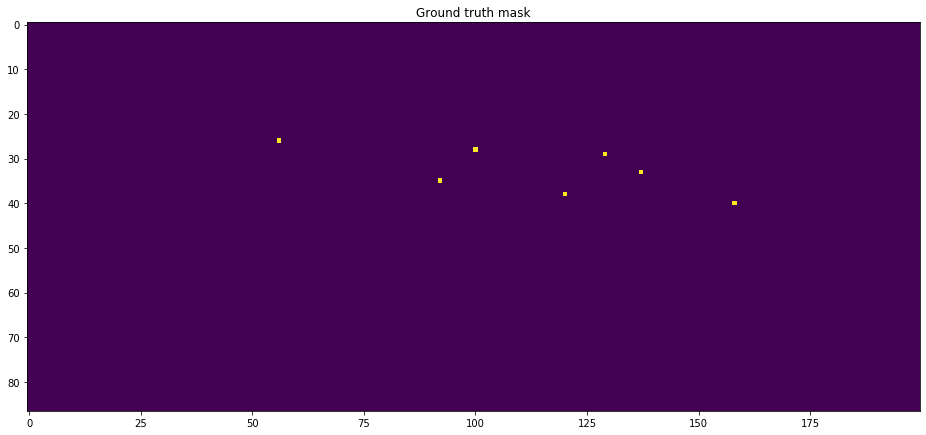

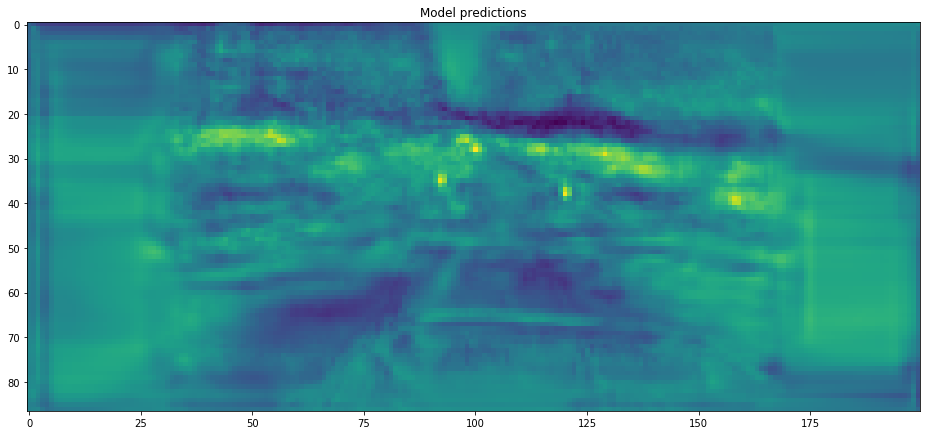

[[-19.460451  -20.811543  -22.663265  ... -14.922461  -15.107616
  -14.280929 ]
 [-19.438047  -16.21816   -18.592155  ... -15.415748  -15.218361
  -15.63019  ]
 [-19.319504  -16.5523    -17.433115  ... -16.075584  -15.183689
  -16.617815 ]
 ...
 [-15.222217  -14.833286  -15.923277  ... -18.323154  -15.973067
  -20.859497 ]
 [-15.807707  -15.8211975 -16.571362  ... -17.376896  -16.41406
  -20.388369 ]
 [-15.57536   -15.203197  -15.154555  ... -16.78011   -16.659986
  -18.70116  ]]


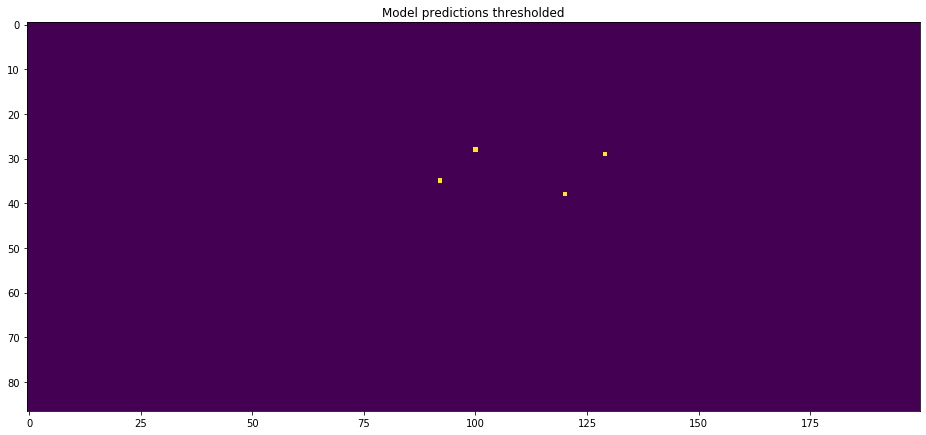

In [106]:
img, mask, regr = dev_loader.dataset[0]

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

print(logits)
plt.figure(figsize=(16,16))
plt.title('Model predictions thresholded')
plt.imshow(logits > 0)
plt.show()

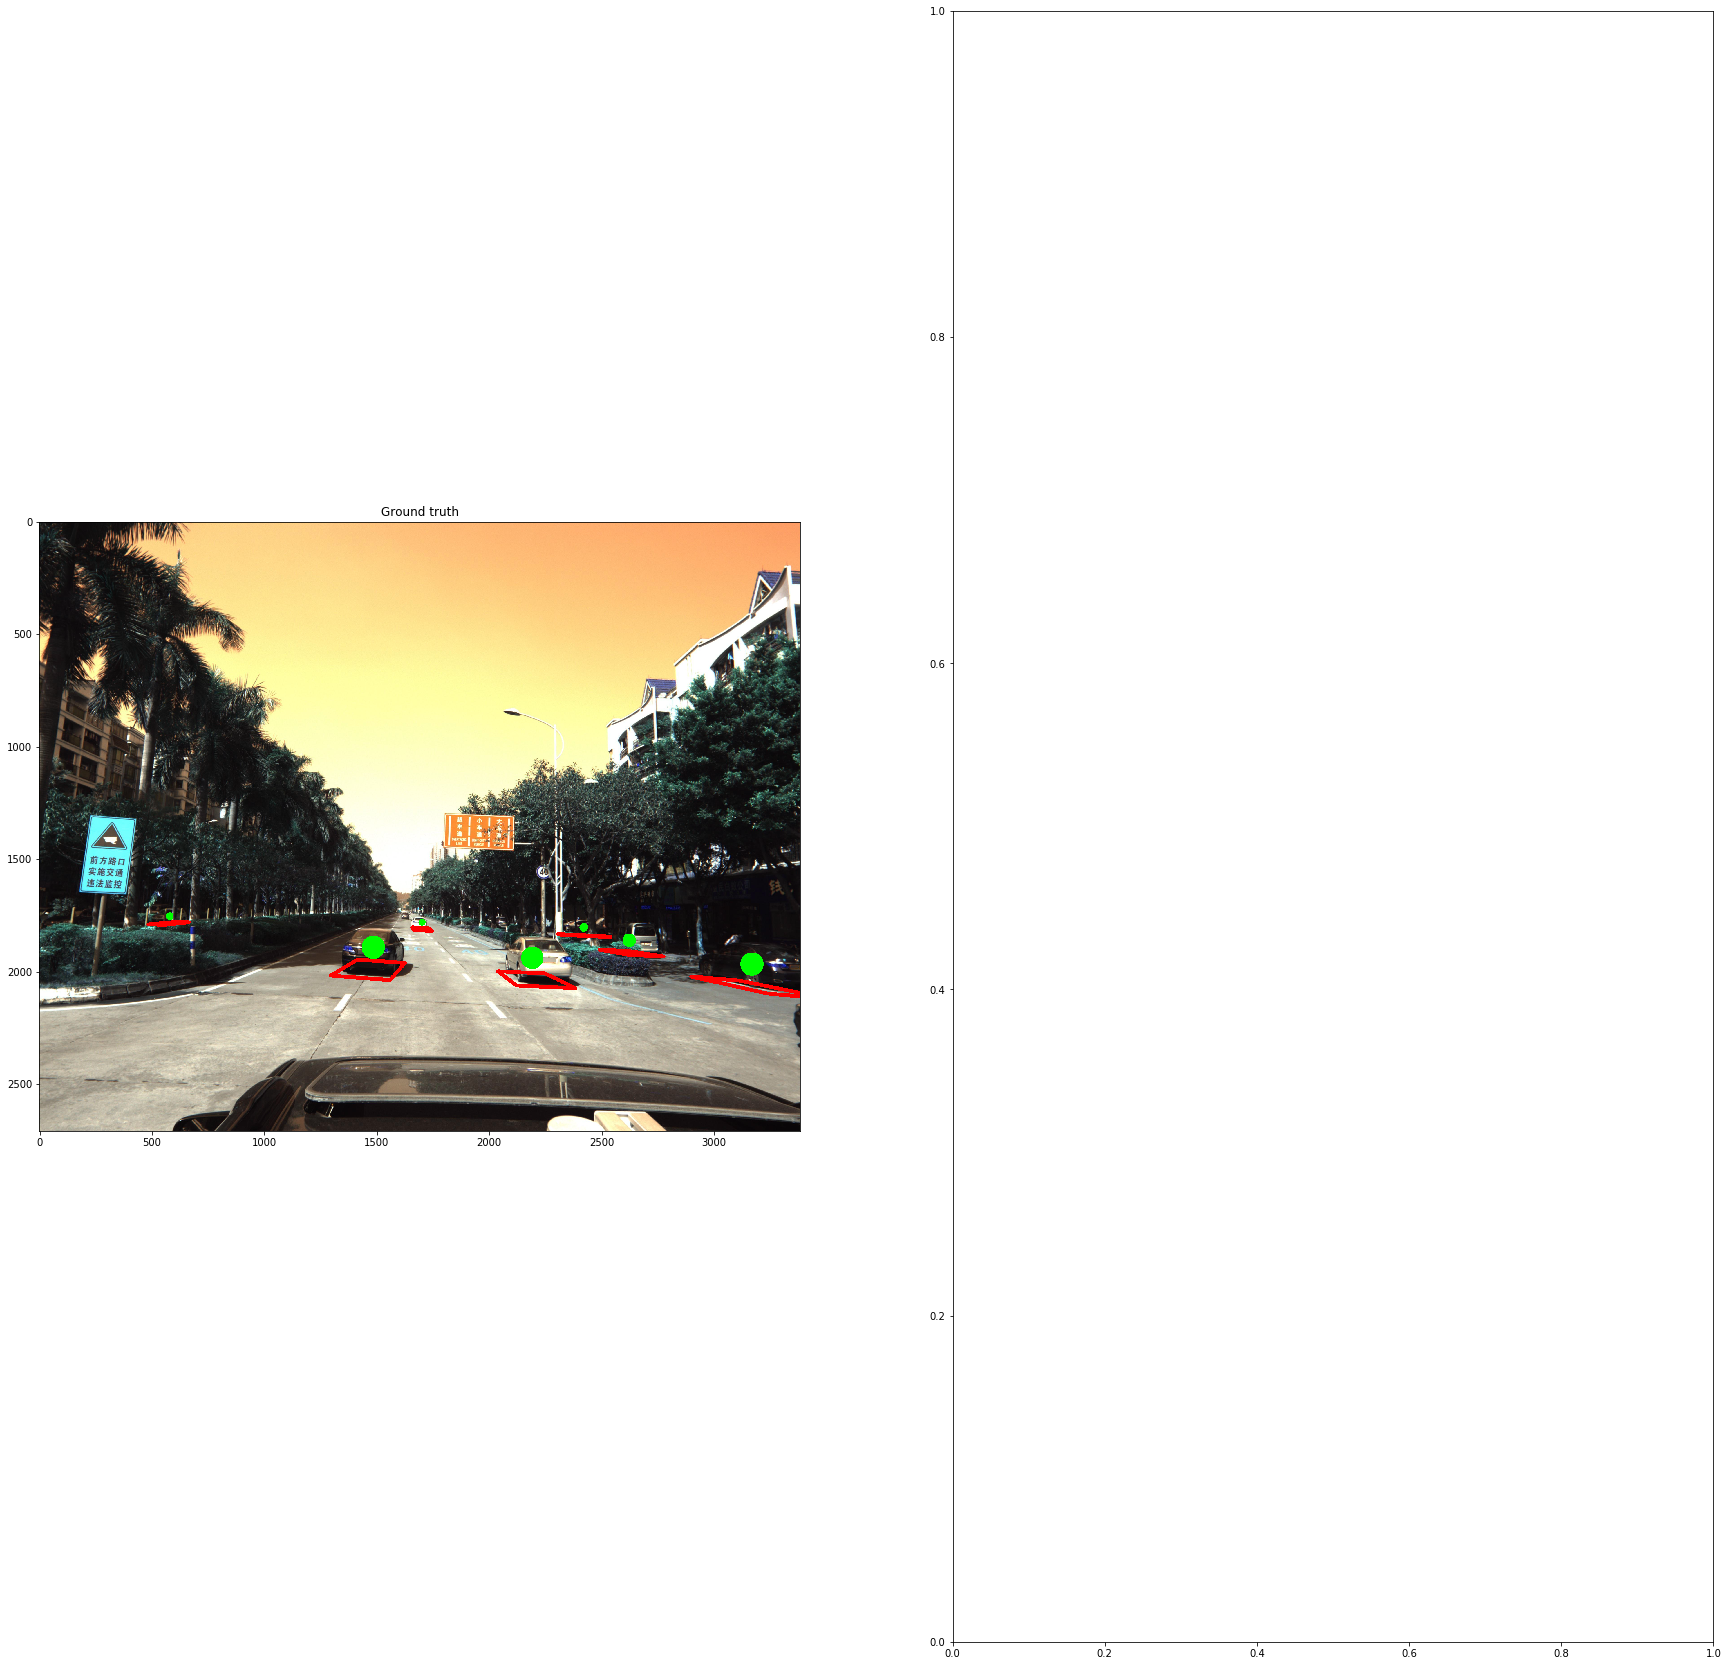

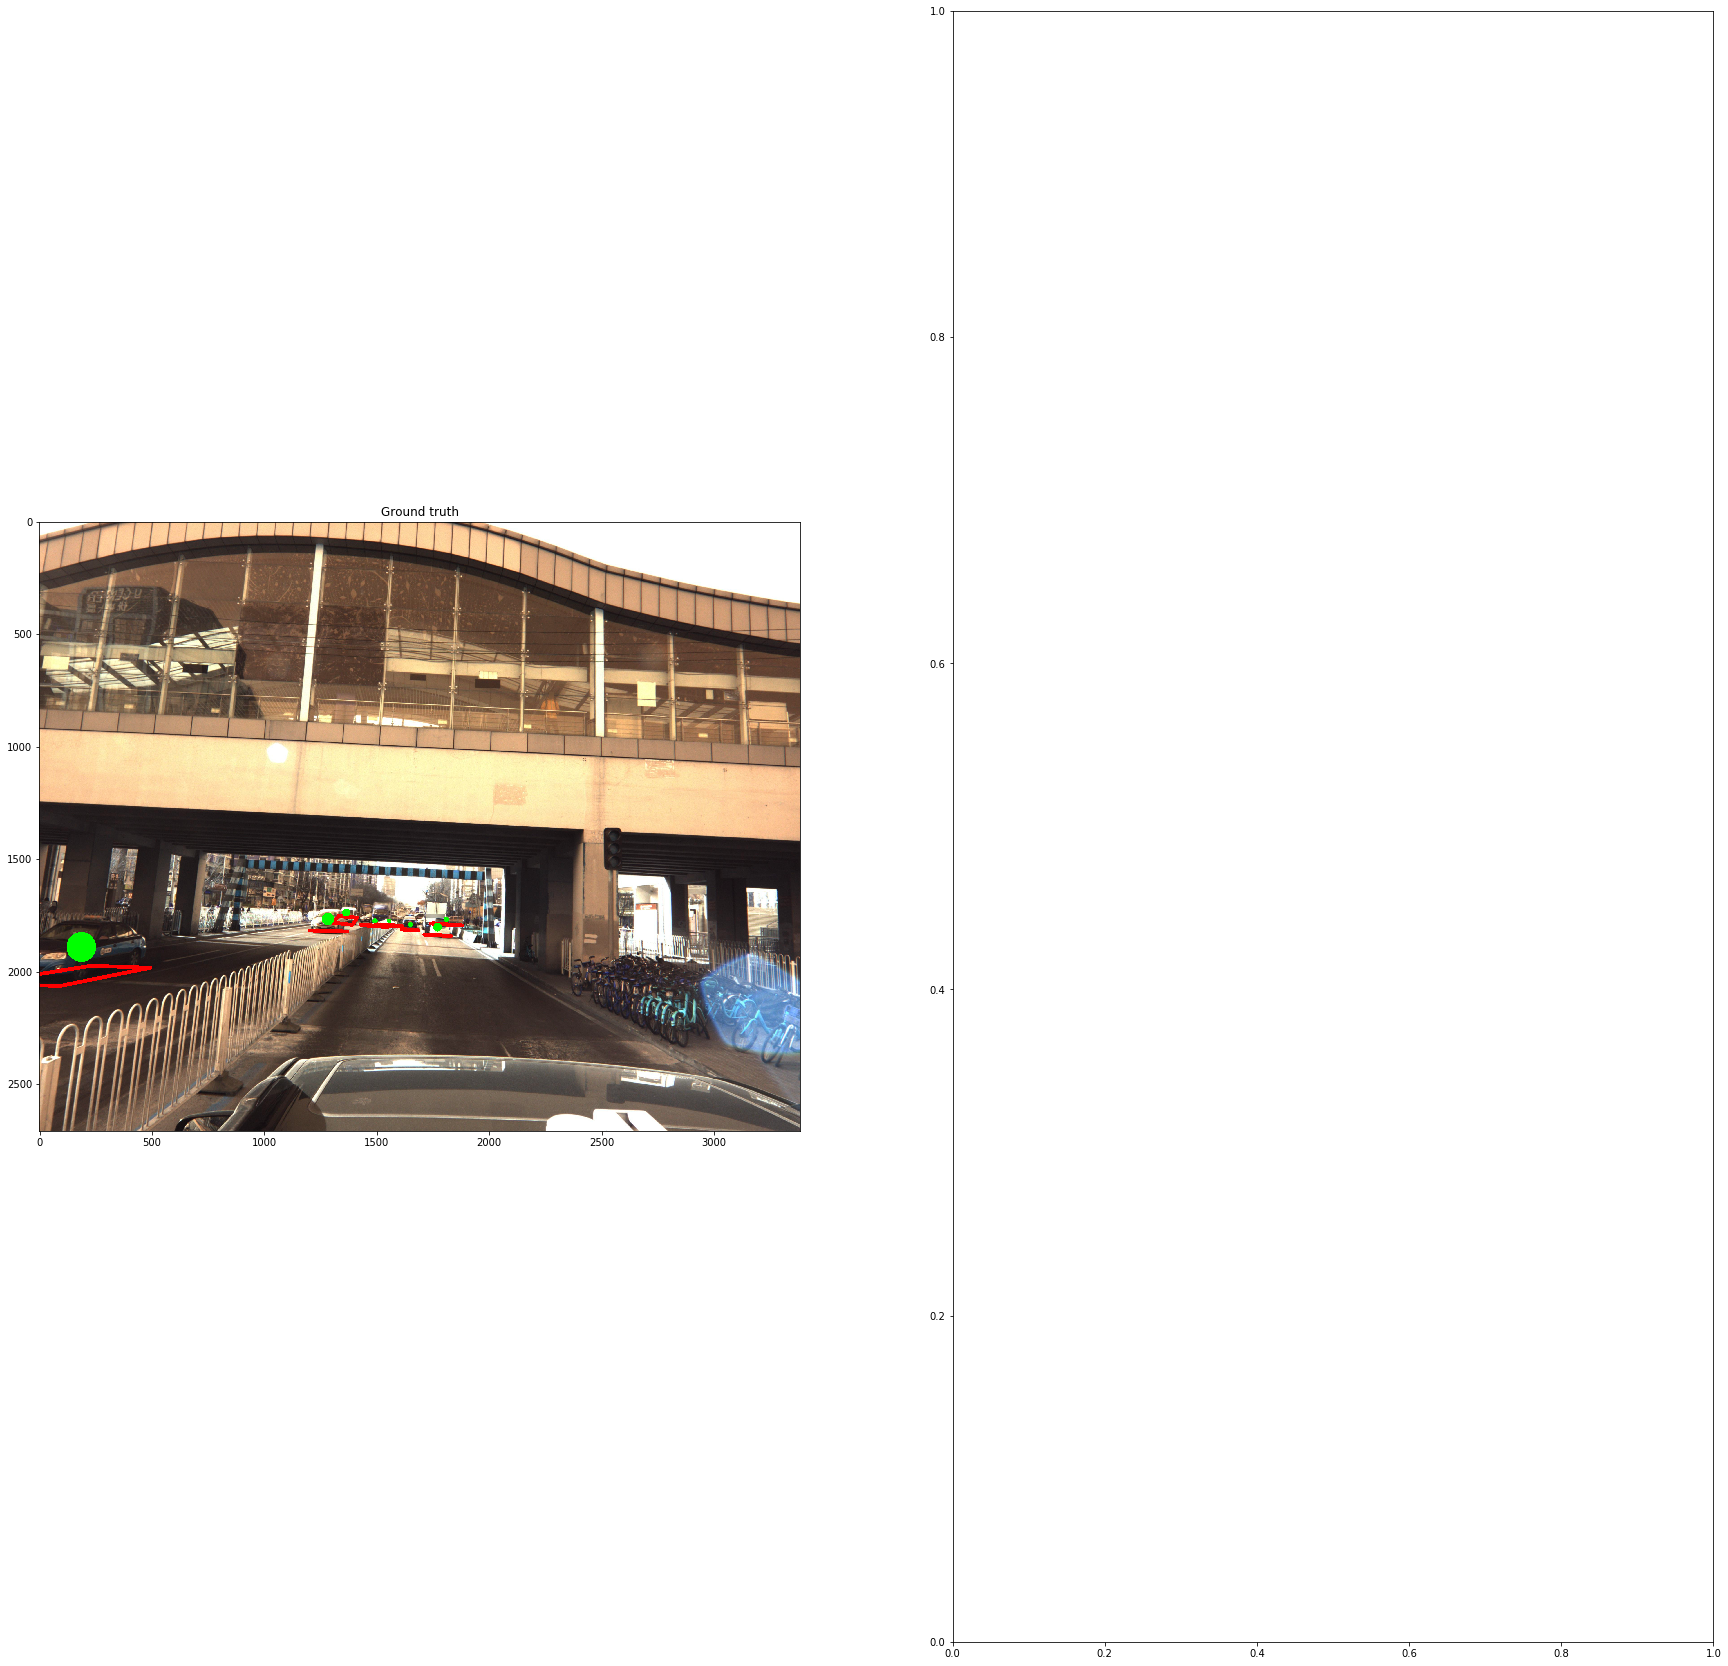

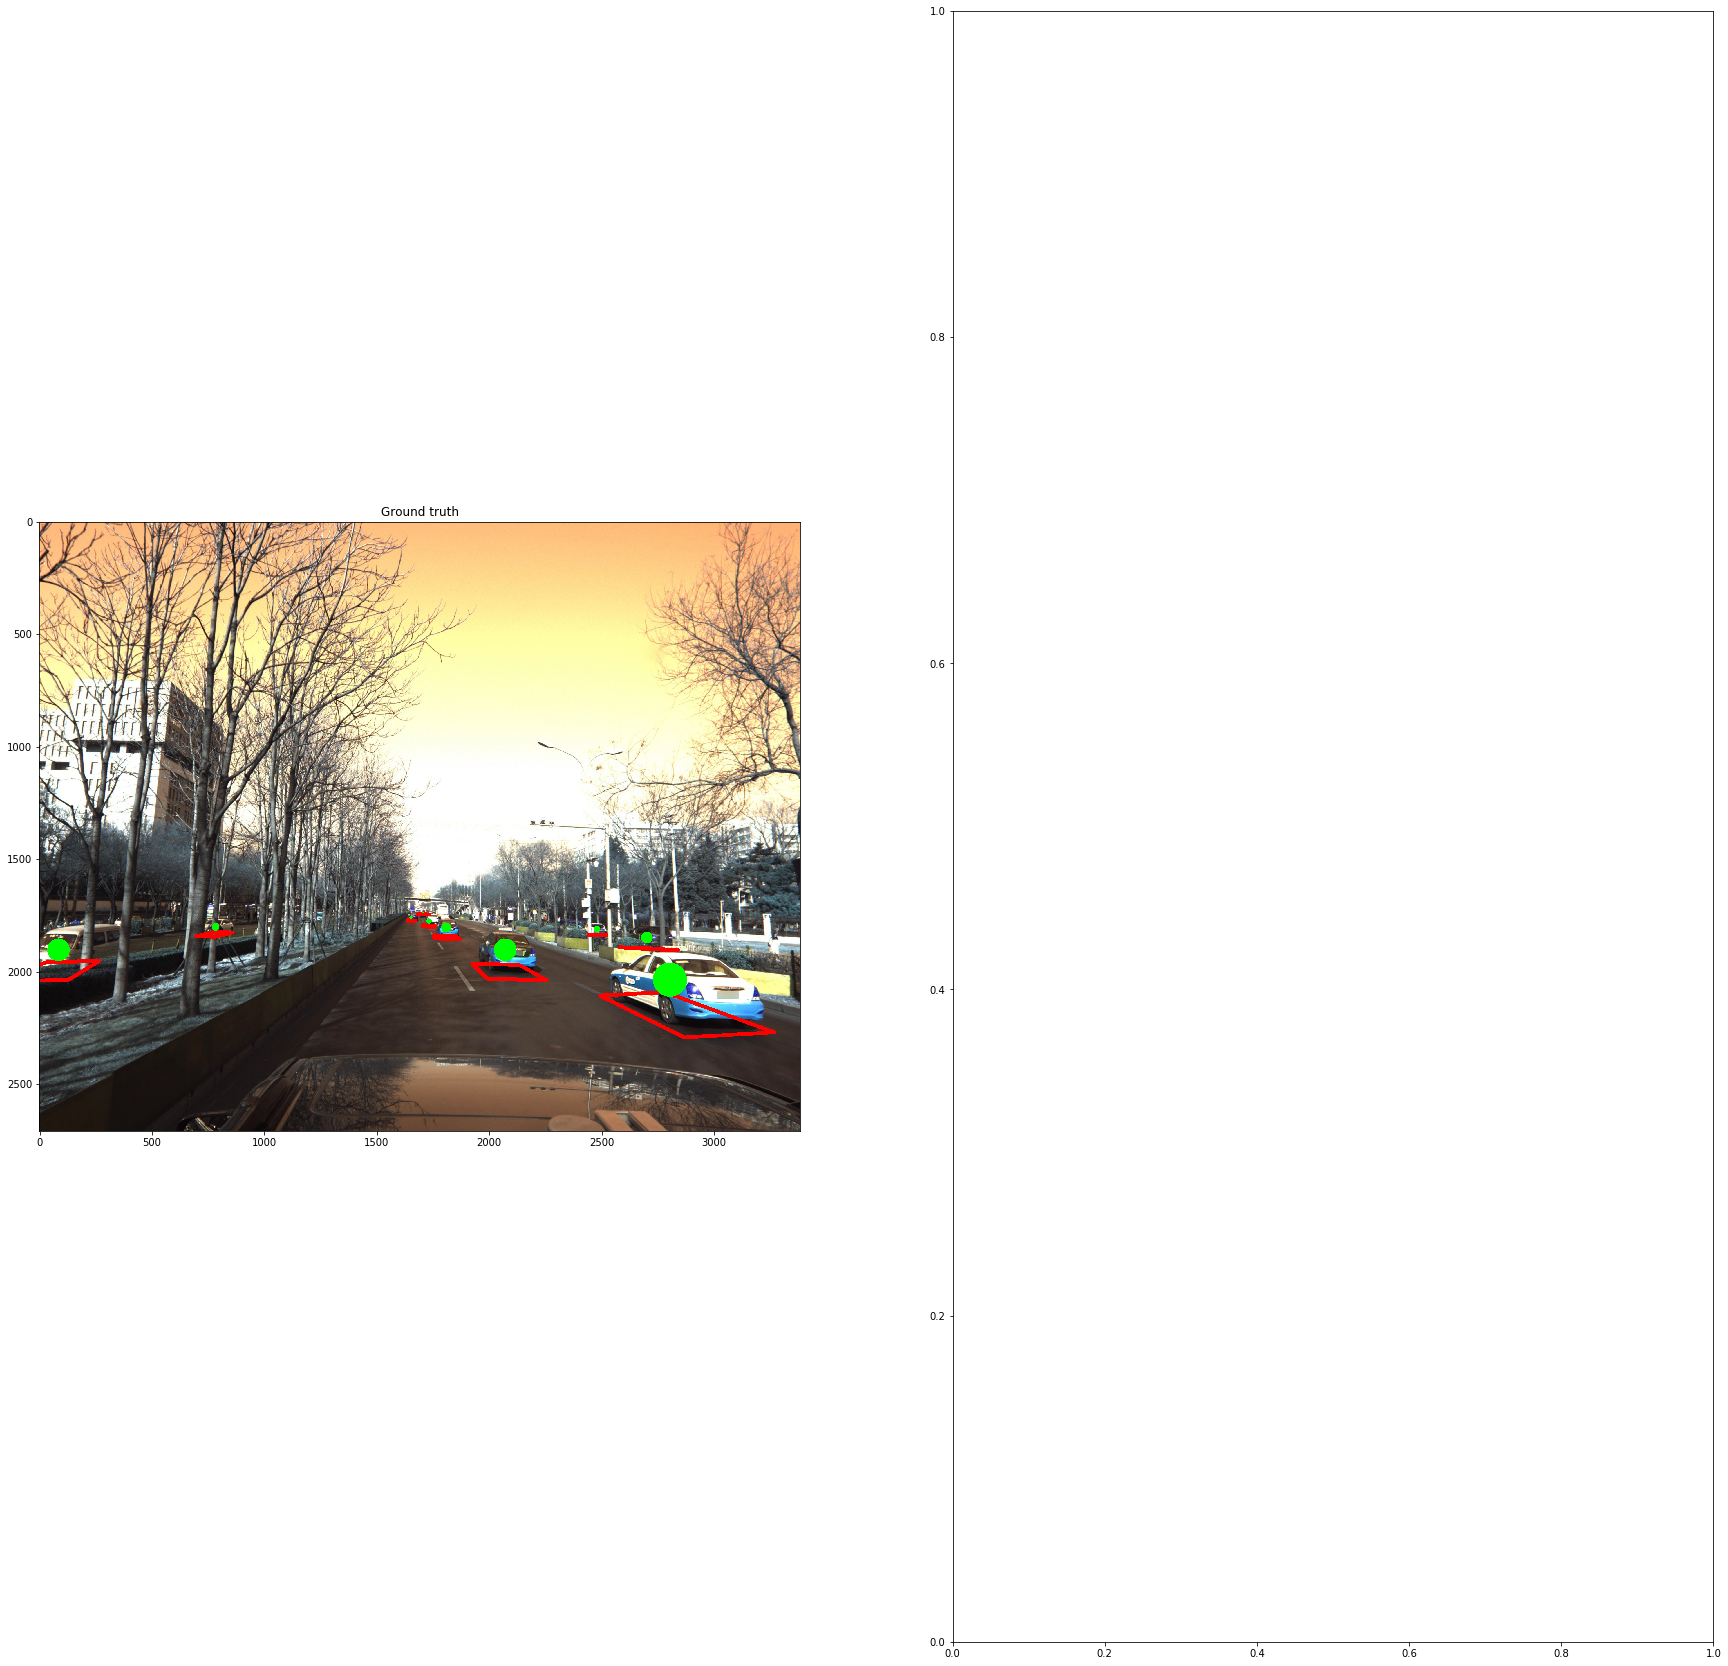

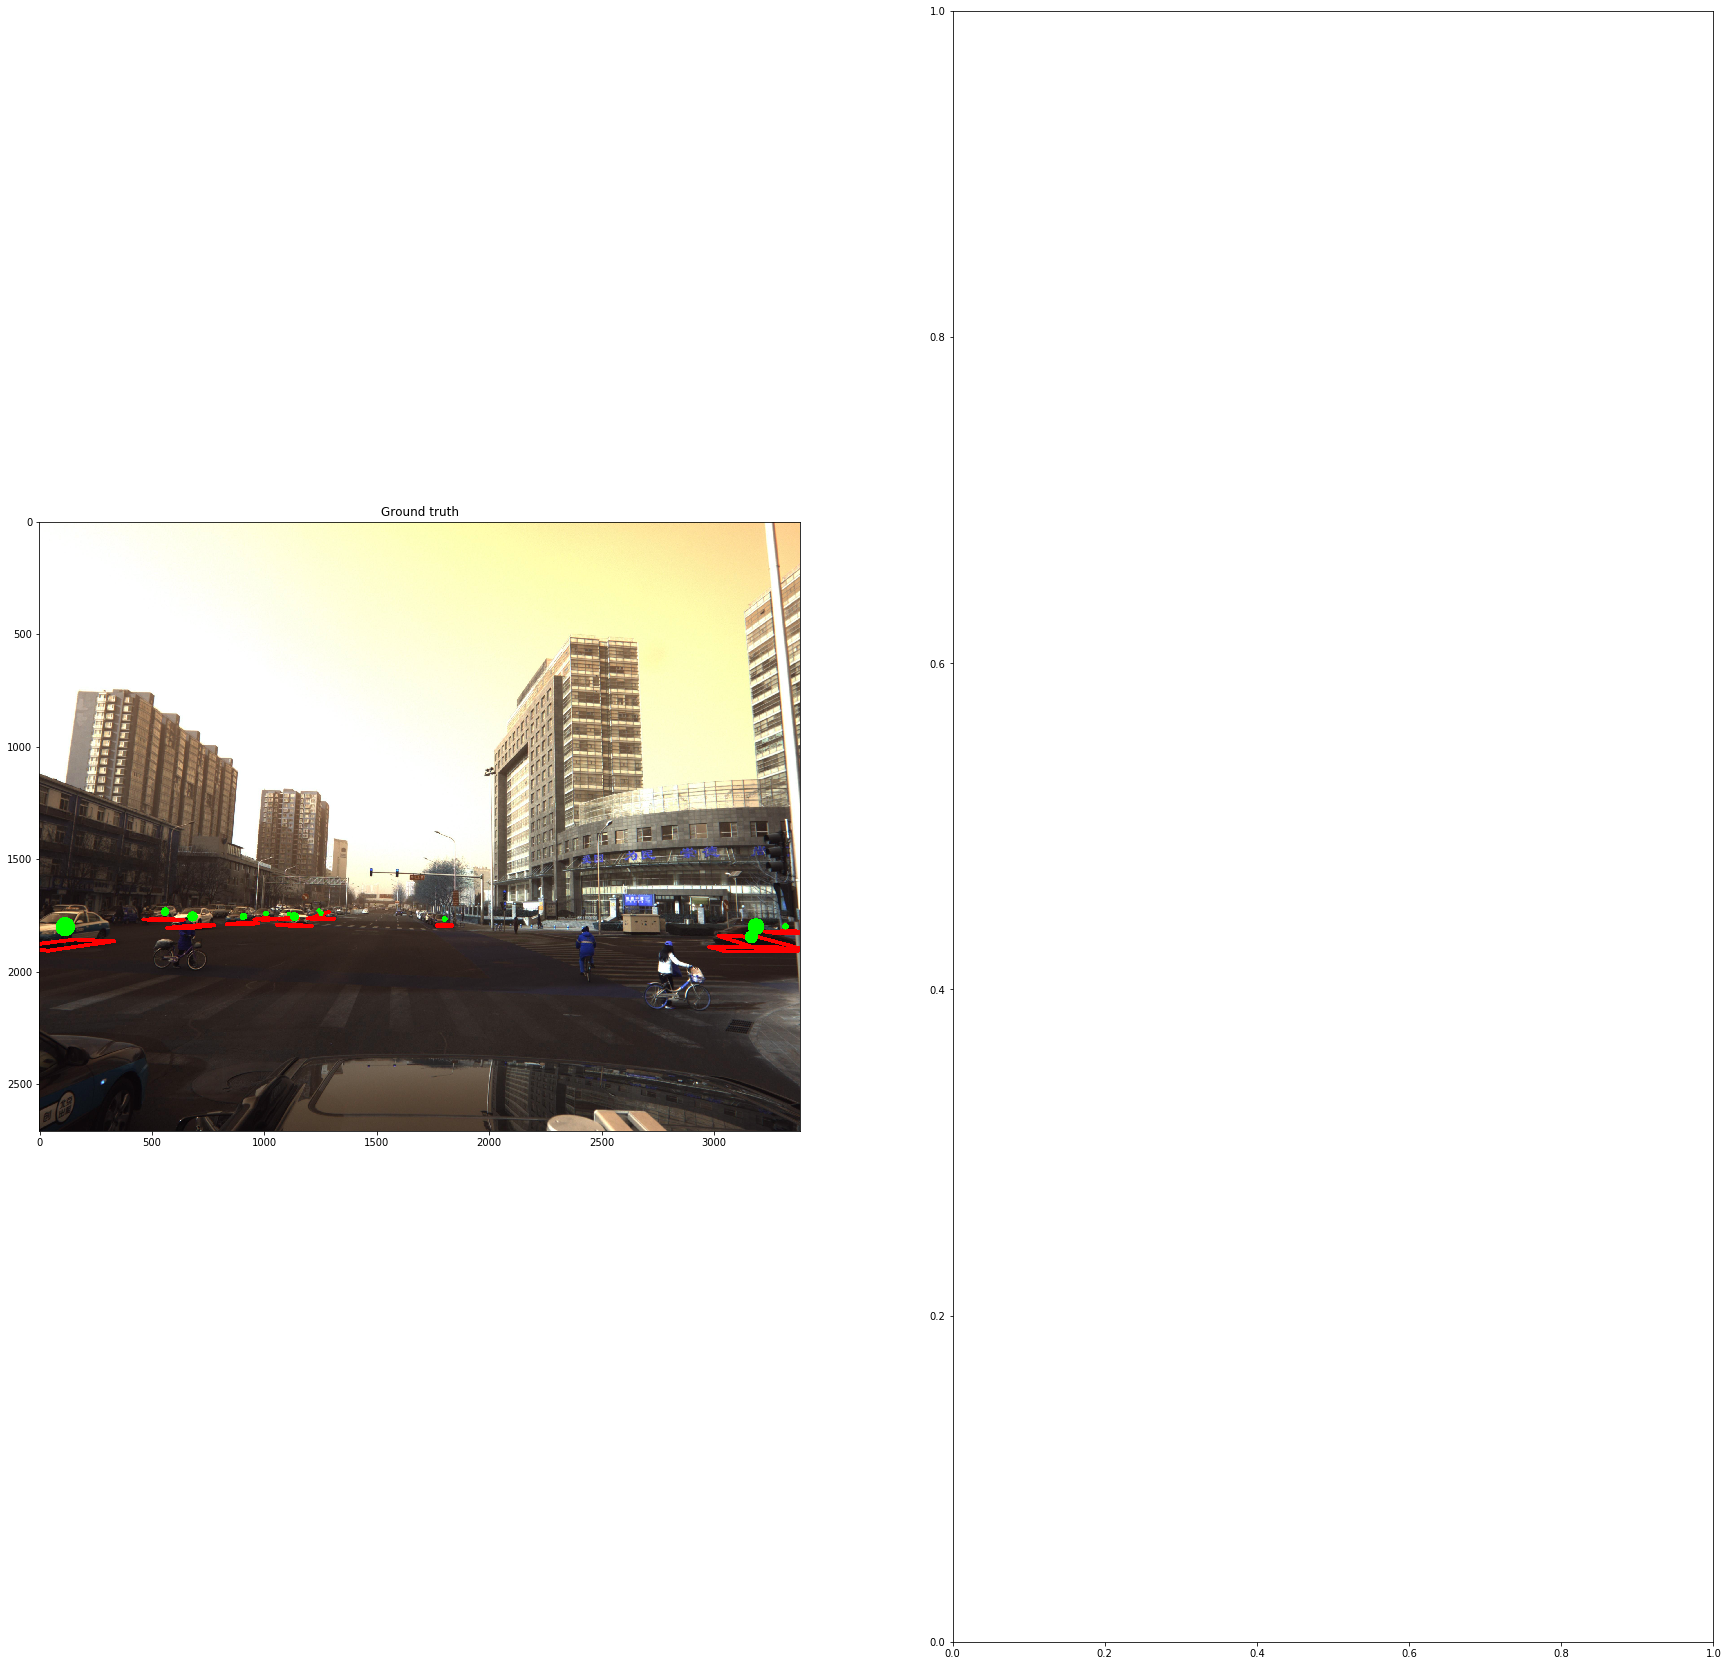

In [152]:
import gc
gc.collect()

for idx in range(4):
    img, mask, regr = dev_loader.dataset[idx] 
    output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()

    img = io.load_image(dev_loader.dataset[idx].image_id)
    coords_pred = util.extract_coords(output[0],img.shape)
    coords_true = util.extract_coords(np.concatenate([mask[None], regr], 0), img.shape)
    
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(graphics.draw_coords(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(graphics.draw_coords(img, coords_pred))
    plt.show()